In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

ny.head()


/Users/cesare/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/cesare/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/cesare/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/cesare/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/cesare/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19,20,22,24,64,65,80) have mixed types.

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter1,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap
1,0.0,NaN,10 JAY STREET,2,834300,10156950,3000010050,163894,O6,195.0,...,1994,2015,1920,NaN,11201.0,M1-4/R8A,M3-1,NaN,NaN,12d
17,0.0,NaN,1 PLYMOUTH STREET,2,129600,351000,3000070021,9585,G1,113.0,...,1988,0,1988,NaN,11201.0,M3-1,NaN,NaN,NaN,12d
20,0.0,NaN,65 PLYMOUTH STREET,2,178200,236700,3000160005,5000,Q0,165.0,...,0,0,1920,NaN,11201.0,PARK,NaN,NaN,NaN,12d
22,0.0,NaN,135 PLYMOUTH STREET,2,514350,7785450,3000180001,211386,D5,48.0,...,2014,0,1900,NaN,11201.0,M1-4/R8A,NaN,NaN,NaN,12d
23,0.0,NaN,20 JAY STREET,2,972000,40980600,3000190001,500000,O6,207.0,...,1999,0,1911,NaN,11201.0,M1-4/R8A,NaN,NaN,NaN,12d


I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AsherMeyers/0 or inside your plot.ly account where it is named 'ny-year-built'


Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Analyzing the Data

The following is the floor analysis of the data.  I first started by converting all floors to a log scale and following the trends across both log scale values and absolute values.  In looking at the collected data, it was determining the binning would not be linear. 

Binning occured by first taking the rounded means of the first few slices (floors 1-10) and then the standard deviation from floors 11-54 followed by double the standard deviation for the higher floors beyond 54.  

In addition, having the data by year would make it hard to determine the trends.  From that perspective the quartiles for the Years Built was also used as the second aggregate to further group the data to determine issues.  



In [6]:
# Start your answer here, inserting more cells as you go along
ny.head()
ny['logFloor'] = np.log(ny.NumFloors)

#analysis of floors
n=pd.DataFrame(list(ny['NumFloors'].describe().transpose()))
n['log']=pd.DataFrame(list(ny['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,1]]
n['step1']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep1']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,3]]
n['step3']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep3']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,5]]
n['step5']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep5']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,7]]
n['step7']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep7']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,9]]
n['step9']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep9']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))


ny2 = ny[ny.logFloor >= n.iloc[1,11]]
n['step11']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep11']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))


ny2 = ny[ny.logFloor >= n.iloc[1,13]]
n['step13']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep13']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,15]]
n['step15']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep15']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))

ny2 = ny[ny.logFloor >= n.iloc[1,17]]
n['step17']=pd.DataFrame(list(ny2['NumFloors'].describe().transpose()))
n['logstep17']=pd.DataFrame(list(ny2['logFloor'].describe().transpose()))
print('The following is the stored data of descriptive summaries as data was sliced based upon the means')
print(n)




The following is the stored data of descriptive summaries as data was sliced based upon the means
               0            log          step1       logstep1         step3  \
0  811782.000000  811782.000000  283231.000000  283231.000000  67909.000000   
1       2.441336       0.786540       3.592254       1.180644      6.126011   
2       1.922320       0.408730       2.884057       0.357222      5.105573   
3       0.500000      -0.693147       2.200000       0.788457      3.300000   
4       2.000000       0.693147       2.500000       0.916291      4.000000   
5       2.000000       0.693147       3.000000       1.098612      5.000000   
6       2.500000       0.916291       3.000000       1.098612      6.000000   
7     119.000000       4.779123     119.000000       4.779123    119.000000   

       logstep3         step5      logstep5        step7     logstep7  \
0  67909.000000  22437.000000  22437.000000  6804.000000  6804.000000   
1      1.679098      9.712696      2.112384 

In [7]:
#with this data we will bin based upon the following method: mean for first few slices, then std deviation as it coalesces at 11, 
#then the balance will be by 2x the std deviation due to the decreasing number of counts.

bins = [0, 5, 10, 21, 32, 43, 54, 76, 98, 119]
labels = ['0-5','6-10','11-21','22-32','33-43','44-54','55-76','77-98','99-119']
ny['binned'] = pd.cut(ny['NumFloors'], bins=bins, labels = labels)

#data is also binned by year to get a better view using only std

bins = [1851, 1870, 1899, 1928, 1957, 1986, 2017]
labels = ['1851+','1871+','1900+','1929+','1958+','1987+']
ny['yearbinned'] = pd.cut(ny['YearBuilt'], bins=bins, labels = labels)

data = ny.groupby(['yearbinned', 'binned']).size().reset_index(name='count')
data['logcount']=np.log(data['count'])
print(data)

x0 = data.loc[data['yearbinned']=='1851+']
x1 = data.loc[data['yearbinned']=='1871+']
x2 = data.loc[data['yearbinned']=='1900+']
x3 = data.loc[data['yearbinned']=='1929+']
x4 = data.loc[data['yearbinned']=='1958+']
x5 = data.loc[data['yearbinned']=='1987+']

print(ny.head())
ny.to_csv(header=True)

   yearbinned  binned   count   logcount
0       1851+     0-5     212   5.356586
1       1851+    6-10      10   2.302585
2       1851+   11-21       2   0.693147
3       1871+     0-5   25800  10.158130
4       1871+    6-10     110   4.700480
5       1871+   11-21      13   2.564949
6       1871+   22-32       1   0.000000
7       1900+     0-5  282344  12.550881
8       1900+    6-10    7766   8.957511
9       1900+   11-21    1682   7.427739
10      1900+   22-32     127   4.844187
11      1900+   33-43      19   2.944439
12      1900+   44-54       4   1.386294
13      1900+   55-76       2   0.693147
14      1929+     0-5  282578  12.551710
15      1929+    6-10    4239   8.352083
16      1929+   11-21     666   6.501290
17      1929+   22-32      86   4.454347
18      1929+   33-43      34   3.526361
19      1929+   44-54      11   2.397895
20      1929+   55-76       7   1.945910
21      1929+   77-98       1   0.000000
22      1929+  99-119       1   0.000000
23      1958+   

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Plotting the Number of Buildings by double categories.

From here, the grouped data was converted to log scale in order to be able to analyze counts by time period equally.

Each time period of years built was plotted side by side using the same y-axis to view the results.  

In [26]:

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x0.iloc[:,1:2].values,
    y = x0.iloc[:,3:4].values,
    name = "1851+"

)


trace1 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x1.iloc[:,1:2].values,
    y = x1.iloc[:,3:4].values,
    name = "1871+"

)

trace2 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x2.iloc[:,1:2].values,
    y = x2.iloc[:,3:4].values,
    name = "1900+"

)

trace3 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x3.iloc[:,1:2].values,
    y = x3.iloc[:,3:4].values,
    name = "1929+"

)

trace4 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x4.iloc[:,1:2].values,
    y = x4.iloc[:,3:4].values,
    name = "1958+"

)

trace5 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = x5.iloc[:,1:2].values,
    y = x5.iloc[:,3:4].values,
    name = "1987+"
)

fig = tools.make_subplots(rows=1, cols=6, shared_yaxes=True)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)
fig.append_trace(trace3, 1, 4)
fig.append_trace(trace4, 1, 5)
fig.append_trace(trace5, 1, 6)

fig['layout']['yaxis1'].update(title='Log Scale Count of Buildings')
fig['layout'].update(height=600, width=600, title='Counts of Buildings Height Categories by Years Built')
py.iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]  [ (1,3) x3,y1 ]  [ (1,4) x4,y1 ]  [ (1,5) x5,y1 ]  [ (1,6) x6,y1 ]



With this information it is clear that those built in the depression and post WW2 era (1900-1957) would be the best candidates to target for inspection reviews.  In this time period, the first bulk of buildings with floors beyond 44 were constructed in higher numbers.  If resources are limited, then begin with those in the floor bin 55-76 in both eras  

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [9]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



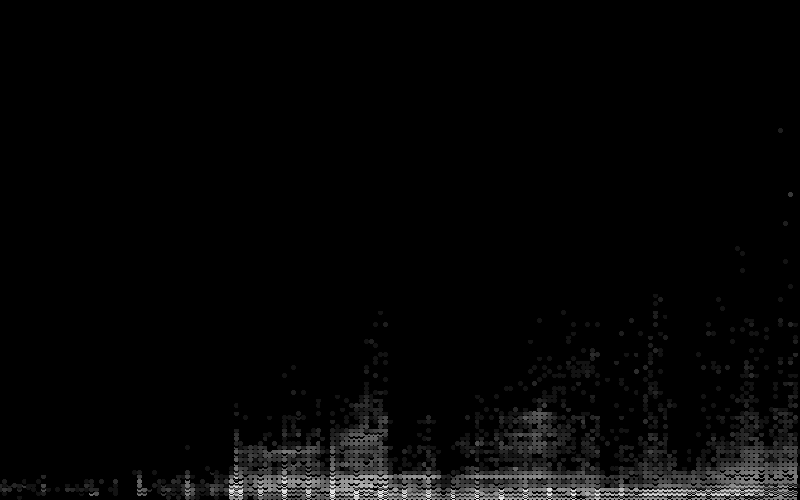

In [10]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

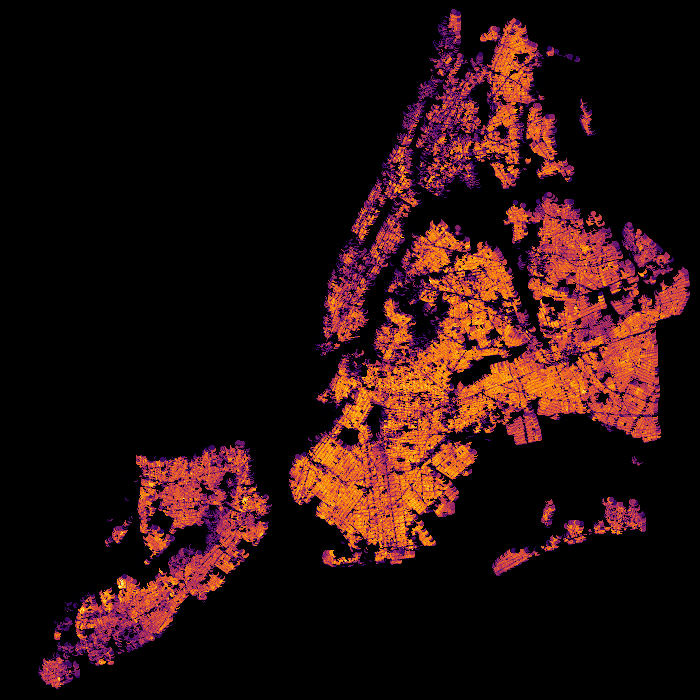

In [11]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### Answer
First we have to calcualted the assessment of the structure which we have to calculate from the availabel columsn (AssessTot and AssessLand).  The new column AssessStruc is calculated as follows:  AssessTot - AssessLand = AssessStruc.  From here the descriptive statistics for each of the two columns (AssessLand and AssessStruc).  

From these values the quartiles were taken as the natural breakpoints for the data.  

Since the AssessStruc is a proxy for landuse this was used as the magnitude variable, those were placed in the tens and the AssessLand was placed in single digits.  From there the values were summed to generate the 'categorical' data using numbers to determine bivariate disparities in land.   

In this case a value of 11 indicates a values in the 0-25% for the Assess Land which corresponds to PURPLE and the Assess Total columns while a values of 44 indicates a value in the 75-100 percentile which corresponds to YELLOW with green being the 50% change.

descriptive summary of AssessLand column
count    8.117820e+05
mean     9.448842e+04
std      3.833980e+06
min      0.000000e+00
25%      7.440000e+03
50%      1.019200e+04
75%      1.493100e+04
max      3.211276e+09
Name: AssessLand, dtype: float64
descriptive summary of AssessTot column
count    8.117820e+05
mean     3.404872e+05
std      7.279018e+06
min      0.000000e+00
25%      1.412100e+04
50%      2.014000e+04
75%      3.142800e+04
max      3.665987e+09
Name: AssessStruc, dtype: float64


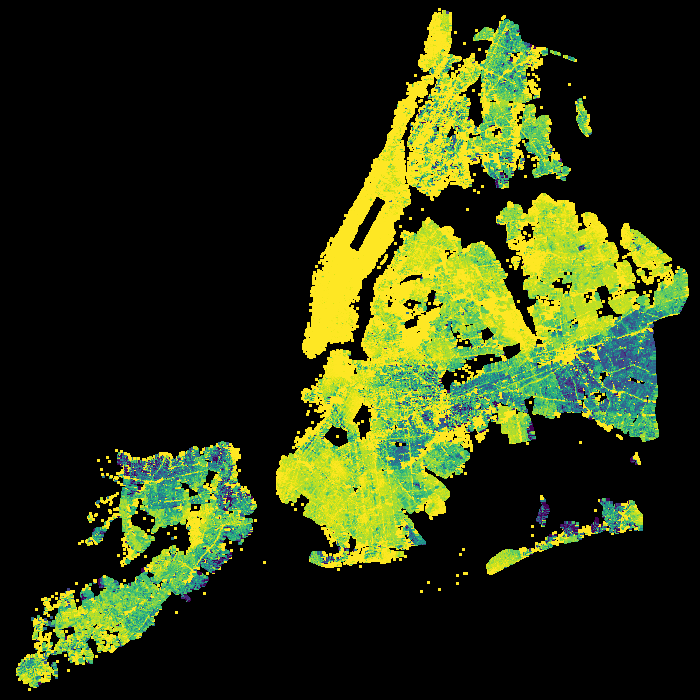

In [17]:
ny['AssessStruc']=ny.AssessTot-ny.AssessLand

print('descriptive summary of AssessLand column')
print(ny['AssessLand'].describe())
print('descriptive summary of AssessTot column')
print(ny['AssessStruc'].describe())

bins = [0, 7440,10192,14931,3211277000]
labels = [1,2,3,4]
ny['biAL'] = pd.cut(ny['AssessLand'], bins=bins, labels = labels)

bins = [0, 14121,20140,31428,3665987000]
labels = [10,20,30,40]
ny['biAS'] = pd.cut(ny['AssessStruc'], bins=bins, labels = labels)


ny['biAL2']=pd.to_numeric(ny['biAL'])
ny['biAS2']=pd.to_numeric(ny['biAS'])
ny['concat2']=ny.biAL2+ny.biAS2

ny.head()

# Map of Assessed Land Values 
NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('concat2'))
view = tf.shade(agg, cmap = cm(viridis), how='log')
export(tf.spread(view, px=1), 'firery')



In [14]:
ny.head()

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,lon,lat,logFloor,binned,yearbinned
1,0.0,NaN,10 JAY STREET,2,834300,10156950,3000010050,163894,O6,195.0,...,M1-4/R8A,M3-1,NaN,NaN,12d,-73.987066,40.704619,2.302585,6-10,1900+
17,0.0,NaN,1 PLYMOUTH STREET,2,129600,351000,3000070021,9585,G1,113.0,...,M3-1,NaN,NaN,NaN,12d,-73.989310,40.704109,0.000000,0-5,1987+
20,0.0,NaN,65 PLYMOUTH STREET,2,178200,236700,3000160005,5000,Q0,165.0,...,PARK,NaN,NaN,NaN,12d,-73.990608,40.704581,0.000000,0-5,1900+
22,0.0,NaN,135 PLYMOUTH STREET,2,514350,7785450,3000180001,211386,D5,48.0,...,M1-4/R8A,NaN,NaN,NaN,12d,-73.988008,40.704131,1.945910,6-10,1900+
23,0.0,NaN,20 JAY STREET,2,972000,40980600,3000190001,500000,O6,207.0,...,M1-4/R8A,NaN,NaN,NaN,12d,-73.987077,40.704101,2.397895,11-21,1900+


### Exagerating plots

The following plot just exacerbates the scale to determine if more clear datapoints appear.  In this scenario the AssessLand column is left in single digits while the AssessStruc is exacerbated using magnitudes.  This is done to determine if exacerbating the values of the data (creating wider gaps) affects how the data coloring occurs.

From the plot below, the areas in the middle are better defined (50% percentile) but the overall look and feel does not change.  Manhattan and the mini downtowns in the 5 boroughs are better defined (pure yellow) but not much else occurs.

In this case a value of 10 indicates a values in the 0-25% for the Assess Land which corresponds to PURPLE and the Assess Total columns while a values of 40,000 indicates a value in the 75-100 percentile which corresponds to YELLOW with green being the 50% range which are the values in the thousands.

The next step would be to begin overlaying this data with census/growth projections to project the 'up and coming neighborhoods.'

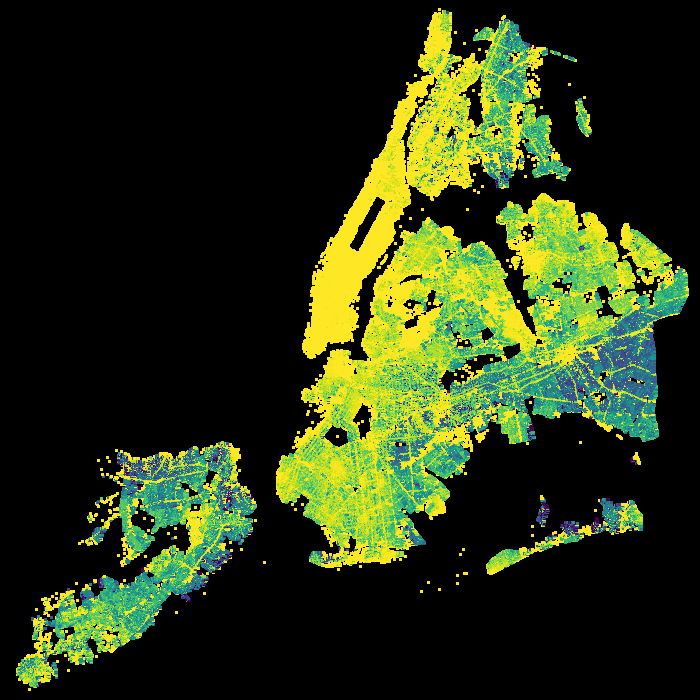

In [18]:
bins = [0, 7440,10192,14931,3211277000]
labels = [1,2,3,4]
ny['biALx'] = pd.cut(ny['AssessLand'], bins=bins, labels = labels)

bins = [0, 14121,20140,31428,3665987000]
labels = [10,100,1000,10000]
ny['biASx'] = pd.cut(ny['AssessStruc'], bins=bins, labels = labels)


ny['biAL3']=pd.to_numeric(ny['biALx'])
ny['biAS3']=pd.to_numeric(ny['biASx'])
ny['concat3']=ny.biAL3*ny.biAS3

ny.head()

# Map of Assessed Land Values 
NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('concat3'))
view = tf.shade(agg, cmap = cm(viridis), how='log')
export(tf.spread(view, px=1), 'firery')